# Connectivity Results

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import os
import mne
import mne_connectivity
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 
import itertools
from plotnine import *

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest


In [2]:
## Prep paths ##

subject = 'BJH027'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_filtered_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if  x]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

# set info as metadata
last_away_epochs.metadata = last_away_data

# onlt good epochs
last_away_epochs = last_away_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events.fif ...


/tmp/ipykernel_4316/1489456339.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [4]:
## Dictionary of electrode locations ##

# Dictionary mapping ROI to elecs
# Pull mapping ROI to elecs
%run /home/brooke/pacman/preprocessing/scripts/roi.py
ROIs = ROIs[subject]

## prep lists

# primary ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in last_away_epochs.info['ch_names']]
bidx = len(last_away_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(last_away_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(last_away_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [5]:
## funcions

def compute_coherence(epochs, ch_names, roi_indices, freqs, n_cycles,  workers = 8):
    """ function to compute TFR via Morlet wavelets
    
    epochs:                     MNE epoch object with channels of interest
    freqs:                      list of frequencies, should be log spaced
    n_cycles:                   number of cycles, adjust with freqs to balance temporal and frequency resolution
    workers:                    number of threads to use while calculating TFR
    """
    print('computing TFR')
    connect = mne_connectivity.spectral_connectivity_epochs(data = epochs,
                                                            names = ch_names,
                                                            method = ['imcoh', 'ppc', 'wpli2_debiased'],
                                                            indices = roi_indices,
                                                            mode = 'cwt_morlet',
                                                            cwt_freqs = freqs,
                                                            cwt_n_cycles = n_cycles,
                                                            n_jobs = workers)

    return connect



def shuffle_epochs(epoch1):
    """
    Shuffles trials in the first epoch object and then combines it with the second epoch object.

    Parameters:
    epoch1 (mne.Epochs): The first epoch object to be shuffled.

    Returns:
    mne.Epochs: The shuffled epoch.
    """

    # Shuffle the first epoch
    indices = np.arange(len(epoch1))
    np.random.shuffle(indices)
    shuffled_epoch1 = epoch1[indices]


    return shuffled_epoch1


def get_indices_of_connectivity_pairs(roi_lists, ch_names):
    """
    Generates indices of channel names corresponding to unique, non-symmetric pairs 
    formed from a list of Regions of Interest (ROIs).

    Parameters:
    roi_lists (list of lists): A list where each element is a list of ROIs (Region of Interest).
                               Each sublist represents a different ROI category.
    ch_names (list): A list of channel names.

    Returns:
    tuple of lists: Two lists containing the indices. The first list contains indices from ch_names 
                    that match the first element of each pair. The second list contains indices from 
                    ch_names that match the second element of each pair.

    Example:
    roi_lists = [roi_list1, roi_list2, ...]
    ch_names = ["ch1", "ch2", "ch3", ...]
    first_pair_indices, second_pair_indices = get_indices_of_connectivity_pairs(roi_lists, ch_names)
    """

    # Generate all unique, non-symmetric pairs from the ROI lists
    pairs = [(item1, item2) for i, list1 in enumerate(roi_lists) 
                            for j, list2 in enumerate(roi_lists) 
                            if i < j 
                            for item1, item2 in itertools.product(list1, list2)]

    # Find indices in ch_names matching the first element of each pair
    first_pair_indices = [idx for pair in pairs 
                                    for idx, roi in enumerate(ch_names) 
                                    if roi == pair[0]]

    # Find indices in ch_names matching the second element of each pair
    second_pair_indices = [idx for pair in pairs 
                                    for idx, roi in enumerate(ch_names) 
                                    if roi == pair[1]]
    
    return first_pair_indices, second_pair_indices

    

In [6]:
## Set frequencies ##

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# delta, theta, hfa
delta_freqs = freqs[np.where((freqs <= 3))]
delta_cycles = n_cycles[np.where((freqs <= 3))]

theta_freqs = freqs[np.where((freqs > 3) & (freqs < 8))]
theta_cycles = n_cycles[np.where((freqs > 3) & (freqs < 8))]

hfa_freqs = freqs[np.where((freqs > 70))]
hfa_cycles = n_cycles[np.where((freqs > 70))]

# resample 
if last_away_epochs.info['sfreq'] > 101:
    last_away_epochs= last_away_epochs.resample(100)

# Crop #
last_away_epochs.crop(tmin = -2.5, tmax = 2.5) 

## remove any electrodes that are duplicated across regions... ugh so much code for such a simple thing ##
# Combine all ROI lists into a single Series
elec_list = pd.Series(hc_list + amyg_list + ofc_list + dlpfc_list + insula_list)

# Identify duplicated elements
duplicated_list = elec_list[elec_list.duplicated()].tolist()

# ROI lists
roi_lists = [hc_list, amyg_list, ofc_list, dlpfc_list, insula_list]

# Find indices of last occurrences of duplicated elements
items_to_remove = [(sub_roi, idx_list) for idx_list, sub_list in enumerate(roi_lists) 
                   for idx, sub_roi in enumerate(sub_list) 
                   if sub_roi in duplicated_list and 
                      idx == len(sub_list) - sub_list[::-1].index(sub_roi) - 1]

# Convert to list of tuples with unique first elements
items_to_remove = list({t[0]: t for t in items_to_remove}.values())

# remove elements
for item in items_to_remove:
    roi_lists[item[1]].remove(item[0])

# reset roi lists
hc_list = roi_lists[0]
amyg_list = roi_lists[1]
ofc_list = roi_lists[2]
dlpfc_list = roi_lists[3]
insula_list = roi_lists[4]
roi_lists = [hc_list, amyg_list, ofc_list, dlpfc_list, insula_list]

# only ROI of interest
last_away_hc = last_away_epochs.copy().pick_channels(hc_list)
last_away_amyg = last_away_epochs.copy().pick_channels(amyg_list)
last_away_ofc = last_away_epochs.copy().pick_channels(ofc_list)
last_away_dlpfc = last_away_epochs.copy().pick_channels(dlpfc_list)
last_away_insula = last_away_epochs.copy().pick_channels(insula_list)

In [7]:
last_away_roi = last_away_hc.copy().add_channels([last_away_amyg, last_away_ofc, last_away_dlpfc, last_away_insula])

In [8]:
## get indicies for all the noon-symmetric pairs ##
first_pair_indices, second_pair_indices = get_indices_of_connectivity_pairs(roi_lists, last_away_roi.info['ch_names'])

## compute connectivity ##
roi_coherence = compute_coherence(last_away_roi, last_away_roi.info.ch_names, (first_pair_indices, second_pair_indices), theta_freqs, theta_cycles, workers = 8)

# pull out different measures #
imcoh = roi_coherence[0].get_data().mean(axis = 1)
ppc = roi_coherence[1].get_data().mean(axis = 1)
pli = roi_coherence[2].get_data().mean(axis = 1)

computing TFR
Connectivity computation...
    computing connectivity for 917 connections
    using t=-2.500s..2.500s for estimation (501 points)
    frequencies: 3.1Hz..7.6Hz (15 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Imaginary Coherence, PPC, Debiased WPLI Square
    computing cross-spectral density for epochs 1..8


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    8.7s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   11.6s finished


    computing cross-spectral density for epochs 9..16


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.3s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.3s finished


    computing cross-spectral density for epochs 17..24


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.6s remaining:    9.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.6s remaining:    4.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.6s finished


    computing cross-spectral density for epochs 25..32


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.0s finished


    computing cross-spectral density for epochs 33..40


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.3s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.3s finished


    computing cross-spectral density for epochs 41..48


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.2s remaining:    4.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.2s finished


    computing cross-spectral density for epochs 49..56


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished


    computing cross-spectral density for epochs 57..64


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.1s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.0s finished


    computing cross-spectral density for epochs 65..72


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.9s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished


    computing cross-spectral density for epochs 73..80


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished


    computing cross-spectral density for epochs 81..88


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished


    computing cross-spectral density for epochs 89..96


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.9s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished


    computing cross-spectral density for epochs 97..104


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished


    computing cross-spectral density for epochs 105..112


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished


    computing cross-spectral density for epochs 113..120


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.9s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished


    computing cross-spectral density for epochs 121..128


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.8s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished


    computing cross-spectral density for epochs 129..136


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.0s finished


    computing cross-spectral density for epochs 137..140


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:    5.1s finished


[Connectivity computation done]


In [3]:
np.save('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/BJH027_imcoh_true.npy', imcoh)
np.save('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/BJH027_ppc_true.npy', ppc)
np.save('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/BJH027_pli_true.npy', pli)

NameError: name 'imcoh' is not defined

In [7]:
# ## Load true data ##
# imcoh = np.load('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/BJH027_imcoh_true.npy')
# ppc = np.load('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/BJH027_ppc_true.npy')
# pli = np.load('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/BJH027_pli_true.npy')

## Load shuffled data ##
imcoh_permutations = np.load('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/perms/BJH021_imcoh_perm.npy')
ppc_permutations = np.load('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/perms/BJH021_ppc_perm.npy')
pli_permutations = np.load('/home/brooke/pacman/across_subject_analyses/ieeg/connectivity/perms/BJH021_pli_perm.npy')

In [6]:
imcoh_permutations.shape[0]/1051

451.0

In [9]:
pli_permutations.shape[0]/1051

451.0

In [14]:
imcoh_permutations = np.reshape(imcoh_permutations,(imcoh.shape[0], 1000, 501))
ppc_permutations = np.reshape(ppc_permutations,(imcoh.shape[0], 1000, 501))
pli_permutations = np.reshape(pli_permutations,(imcoh.shape[0], 1000, 501))

In [15]:
first_pair_indices, second_pair_indices = get_indices_of_connectivity_pairs(roi_lists, last_away_roi.info['ch_names'])
pairs_tested = [(last_away_roi.info['ch_names'][x], last_away_roi.info['ch_names'][y]) for x, y in zip(first_pair_indices, second_pair_indices)]

In [18]:
imcoh.shape

(917, 501)

In [19]:
imcoh_pvalues = np.zeros((imcoh.shape[0], imcoh.shape[1]))
ppc_pvalues = np.zeros((imcoh.shape[0], imcoh.shape[1]))
pli_pvalues = np.zeros((imcoh.shape[0], imcoh.shape[1]))

for pair in range(0, imcoh.shape[0]):

    # calculate imcoh p-values
    null_greater_than_imcoh = np.abs(imcoh[pair, :]) <= np.abs(imcoh_permutations[pair, :, :]) 
    percent_null_greater_than_imcoh = np.sum(null_greater_than_imcoh, axis = 0)/1000
    _, imcoh_fdr, _, _, = multitest.multipletests(percent_null_greater_than_imcoh, alpha = 0.05, method = 'fdr_bh')
    imcoh_pvalues[pair, :] =  imcoh_fdr

    # calculate ppc p-values
    null_greater_than_ppc = ppc[pair, :] <= ppc_permutations[pair, :, :]
    percent_null_greater_than_ppc = np.sum(null_greater_than_ppc, axis = 0)/1000
    _, ppc_fdr, _, _, = multitest.multipletests(percent_null_greater_than_ppc, alpha = 0.05, method = 'fdr_bh')
    ppc_pvalues[pair, :] = ppc_fdr

    # calculate pli p-values
    null_greater_than_pli = pli[pair, :] <= pli_permutations[pair, :, :]
    percent_null_greater_than_pli = np.sum(null_greater_than_pli, axis = 0)/1000
    _, pli_fdr, _, _, = multitest.multipletests(percent_null_greater_than_pli, alpha = 0.05, method = 'fdr_bh')
    pli_pvalues[pair, :] = pli_fdr



## HC Connectivity

In [20]:
hc_imcoh_pvalues = np.zeros((5, imcoh.shape[1]))
hc_ppc_pvalues = np.zeros((5, imcoh.shape[1]))
hc_pli_pvalues = np.zeros((5, imcoh.shape[1]))

for idx, roi_list in enumerate([amyg_list, ofc_list, cing_list, dlpfc_list, insula_list]):
    first, second = get_indices_of_connectivity_pairs([hc_list, roi_list], last_away_roi.info['ch_names'])
    pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]


    ### IMCOH ###
    hc_amyg_imcoh_pvals = imcoh_pvalues[pair_indices, :]
    hc_amyg_imcoh_sig = hc_amyg_imcoh_pvals <= 0.05
    hc_amyg_imcoh_counts = np.sum(hc_amyg_imcoh_sig, axis =0)/len(pair_indices)

    ### PPC ###
    hc_amyg_ppc_pvals = ppc_pvalues[pair_indices, :]
    hc_amyg_ppc_sig = hc_amyg_ppc_pvals <= 0.05
    hc_amyg_ppc_counts = np.sum(hc_amyg_ppc_sig, axis =0)/len(pair_indices)

    ### PLI ###
    hc_amyg_pli_pvals = pli_pvalues[pair_indices, :]
    hc_amyg_pli_sig = hc_amyg_pli_pvals <= 0.05
    hc_amyg_pli_counts = np.sum(hc_amyg_pli_sig, axis =0)/len(pair_indices)


    hc_imcoh_pvalues[idx, :] =  hc_amyg_imcoh_counts
    hc_ppc_pvalues[idx, :] = hc_amyg_ppc_counts
    hc_pli_pvalues[idx, :] = hc_amyg_pli_counts


## prep dataframes for plotting ##
# imcoh
hc_imcoh_df = pd.DataFrame(np.transpose(hc_imcoh_pvalues), columns = ['amyg', 'ofc', 'cing', 'dlpfc', 'insula'])
hc_imcoh_df['time'] = last_away_roi.times
hc_imcoh_df = hc_imcoh_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_imcoh_df['metric'] = 'Imaginary Coherence'

# ppc
hc_ppc_df = pd.DataFrame(np.transpose(hc_ppc_pvalues), columns = ['amyg', 'ofc', 'cing', 'dlpfc', 'insula'])
hc_ppc_df['time'] = last_away_roi.times
hc_ppc_df = hc_ppc_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_ppc_df['metric'] = 'Pairwise Phase Consistency'

# pli
hc_pli_df = pd.DataFrame(np.transpose(hc_pli_pvalues), columns = ['amyg', 'ofc', 'cing', 'dlpfc', 'insula'])
hc_pli_df['time'] = last_away_roi.times
hc_pli_df = hc_pli_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_pli_df['metric'] = 'Weighted/Corrected Phase Lag Index'

# combine
hc_df = pd.concat([hc_imcoh_df, hc_ppc_df, hc_pli_df])
hc_df


/tmp/ipykernel_4316/1540183999.py:13: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/1540183999.py:13: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_4316/1540183999.py:18: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/1540183999.py:18: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_4316/1540183999.py:23: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/1540183999.py:23: RuntimeWarning: invalid value encountered in divide


,time,region,percent_sig,metric
0,-2.50,amyg,0.090909,Imaginary Coherence
1,-2.49,amyg,0.136364,Imaginary Coherence
2,-2.48,amyg,0.136364,Imaginary Coherence
3,-2.47,amyg,0.136364,Imaginary Coherence
4,-2.46,amyg,0.136364,Imaginary Coherence
...,...,...,...,...
2500,2.46,insula,0.155556,Weighted/Corrected Phase Lag Index
2501,2.47,insula,0.155556,Weighted/Corrected Phase Lag Index
2502,2.48,insula,0.155556,Weighted/Corrected Phase Lag Index
2503,2.49,insula,0.155556,Weighted/Corrected Phase Lag Index


/home/brooke/mambaforge/envs/ieeg_analysis2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1503 rows containing missing values.


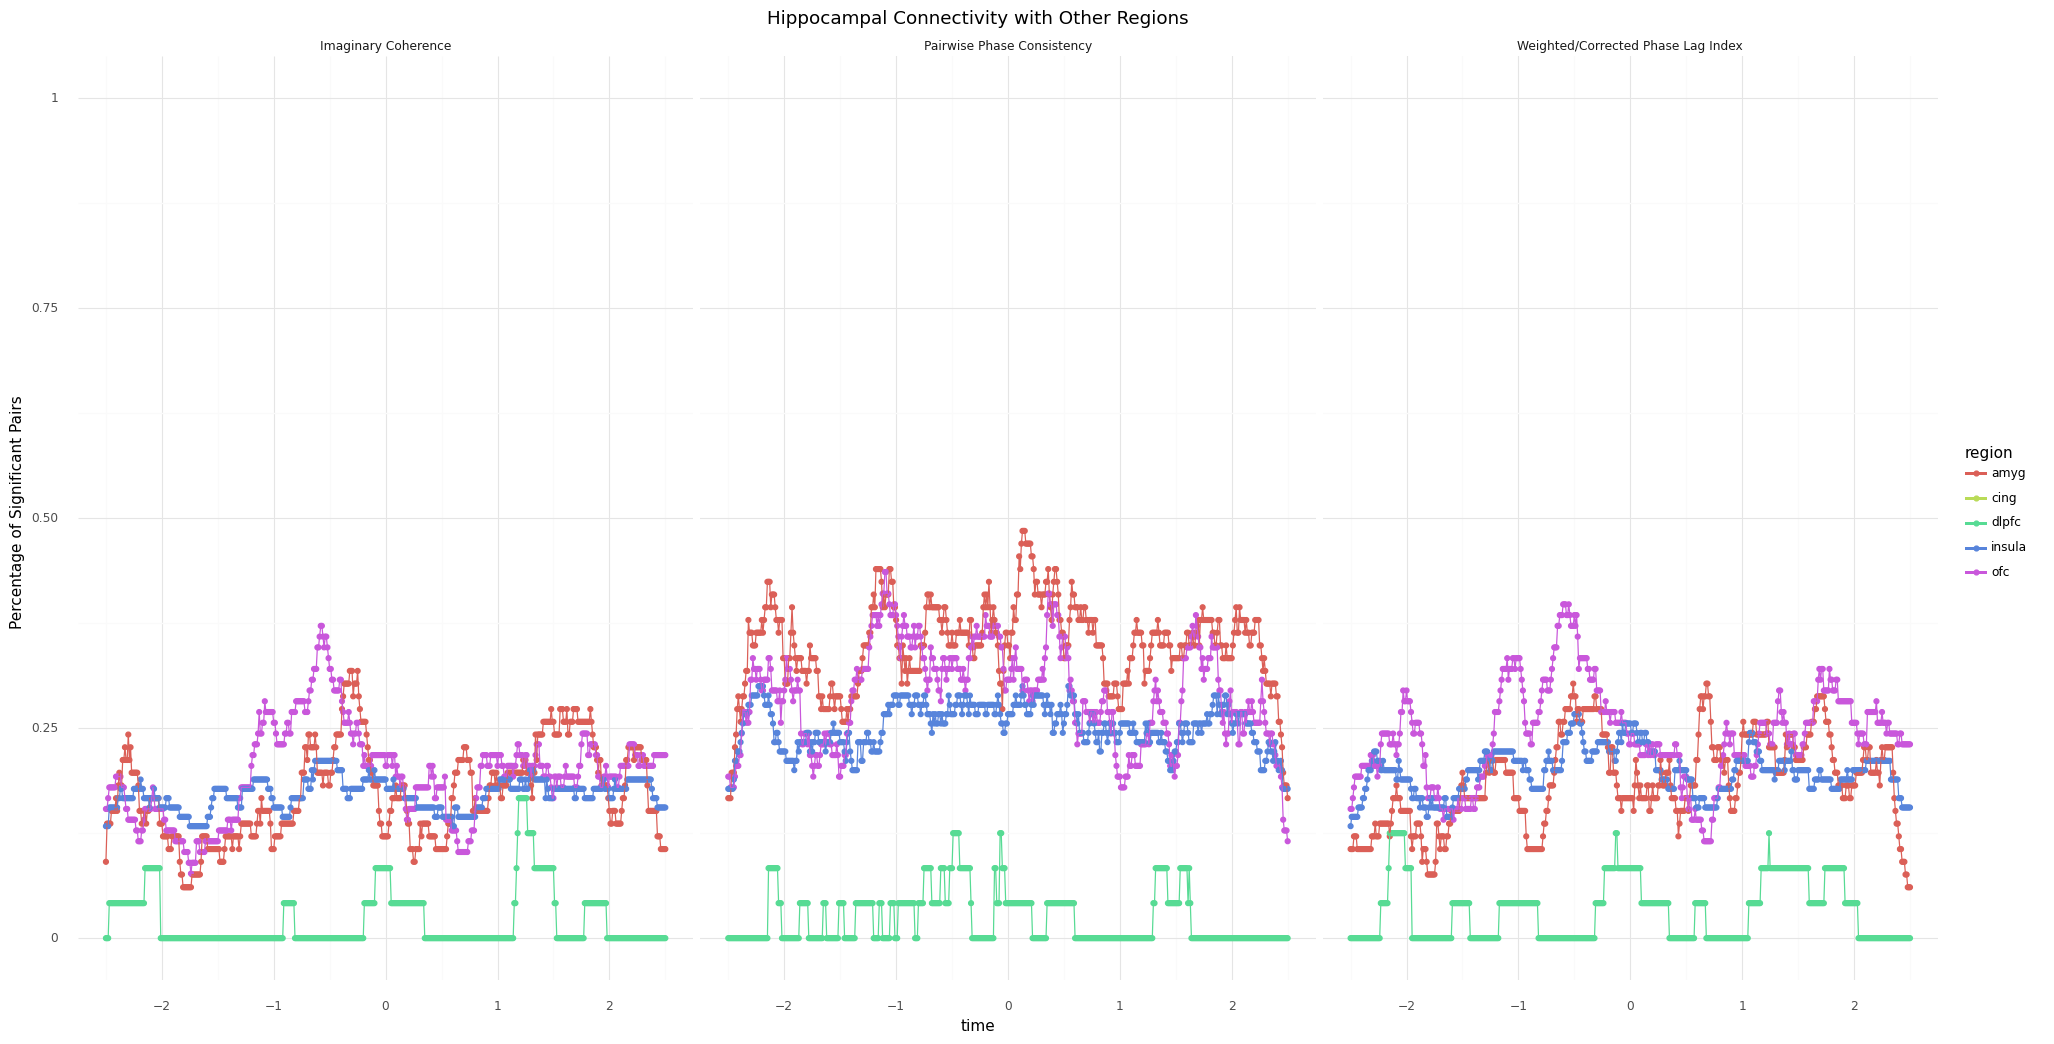

<ggplot: (8734714550221)>

In [22]:

(ggplot(hc_df, aes(x='time', y='percent_sig', color = 'region')) + 
    geom_point() +
    geom_line() +
    facet_wrap('metric', ncol = 3) +
    theme_minimal() +
    ylim(0, 1) +
    ylab("Percentage of Significant Pairs")+
    ggtitle('Hippocampal Connectivity with Other Regions') +
    theme(figure_size=(24, 12))) 


## Amygdala Connectivity

/tmp/ipykernel_4316/2940304749.py:13: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/2940304749.py:13: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_4316/2940304749.py:18: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/2940304749.py:18: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_4316/2940304749.py:23: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/2940304749.py:23: RuntimeWarning: invalid value encountered in divide
/home/brooke/mambaforge/envs/ieeg_analysis2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1503 rows containing missing values.
/home/brooke/mambaforge/envs/ieeg_analysis2/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 501 rows containing missing values.


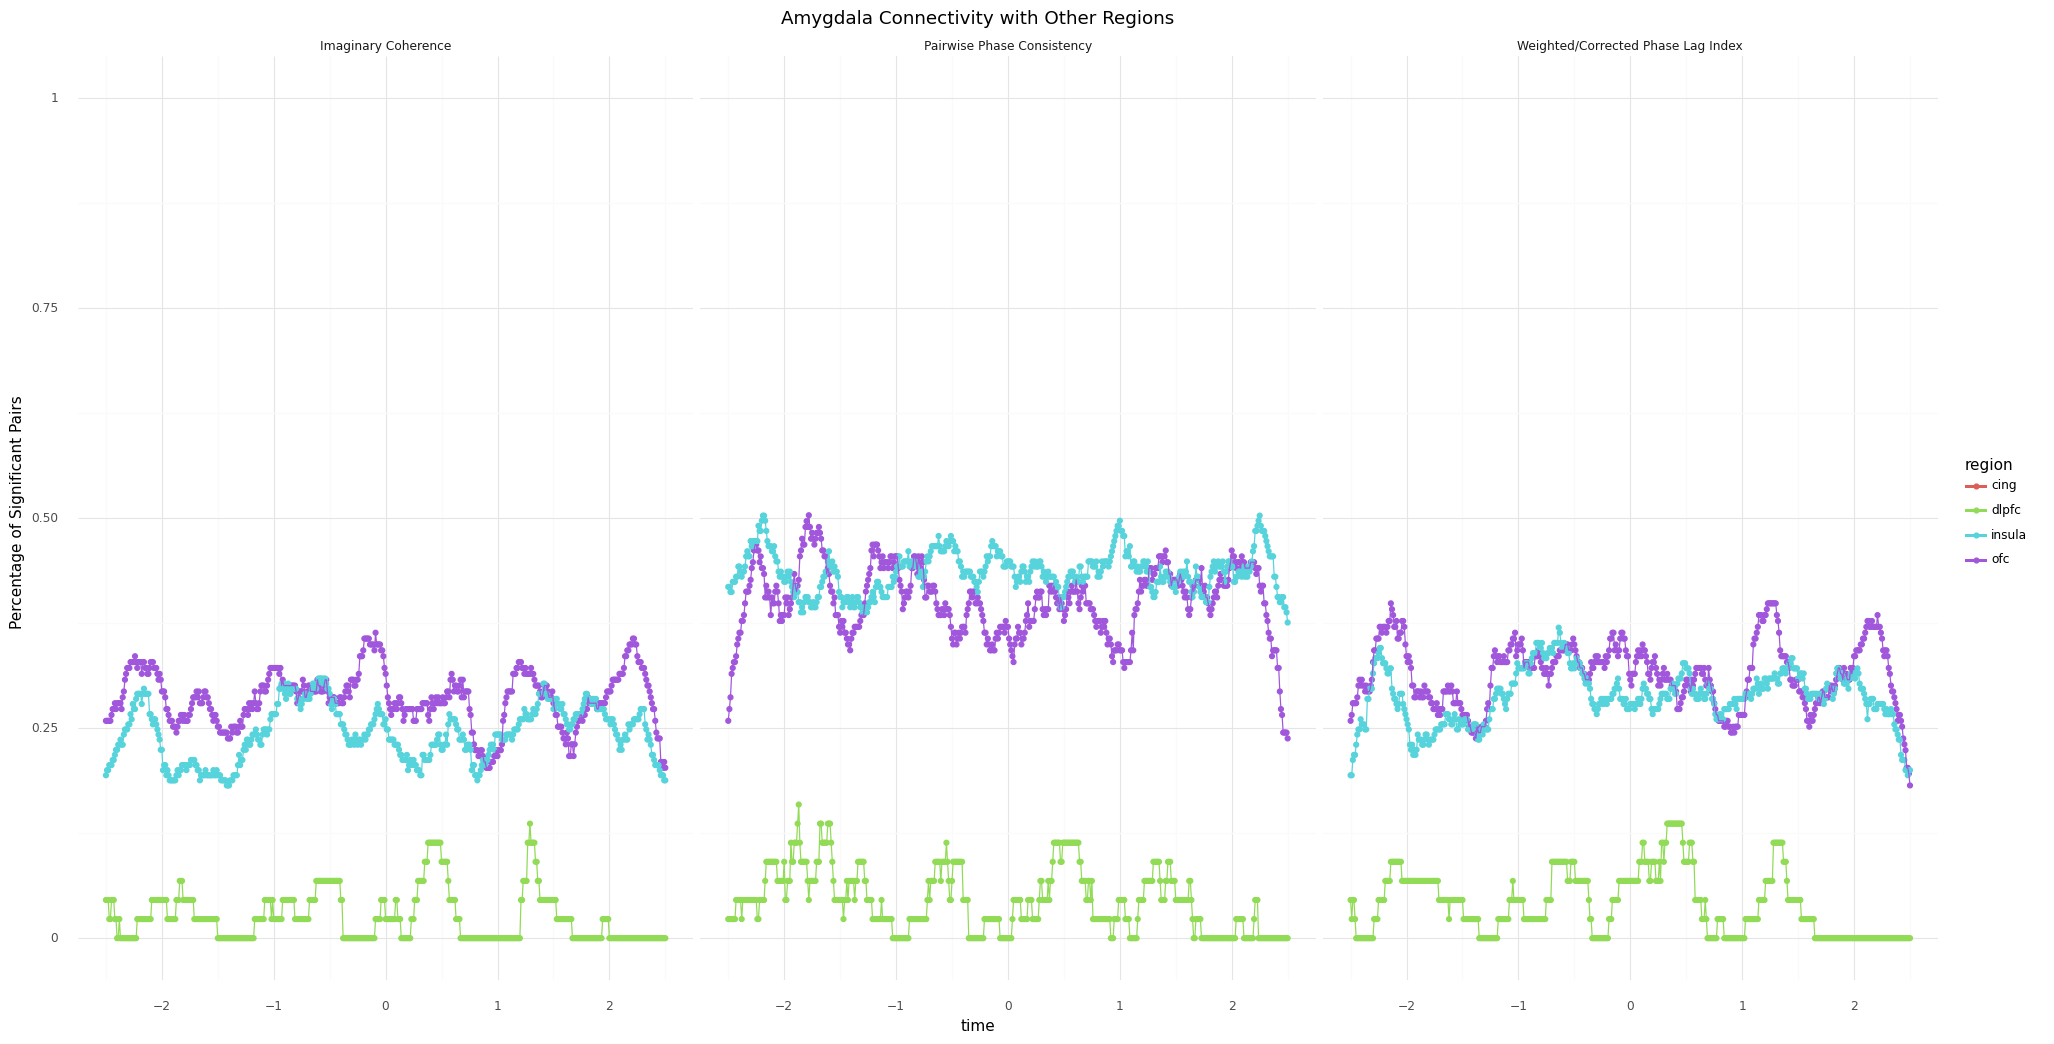

<ggplot: (8734714370256)>

In [23]:
hc_imcoh_pvalues = np.zeros((4, imcoh.shape[1]))
hc_ppc_pvalues = np.zeros((4, imcoh.shape[1]))
hc_pli_pvalues = np.zeros((4, imcoh.shape[1]))

for idx, roi_list in enumerate([ofc_list, cing_list, dlpfc_list, insula_list]):
    first, second = get_indices_of_connectivity_pairs([amyg_list, roi_list], last_away_roi.info['ch_names'])
    pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]


    ### IMCOH ###
    hc_amyg_imcoh_pvals = imcoh_pvalues[pair_indices, :]
    hc_amyg_imcoh_sig = hc_amyg_imcoh_pvals <= 0.05
    hc_amyg_imcoh_counts = np.sum(hc_amyg_imcoh_sig, axis =0)/len(pair_indices)

    ### PPC ###
    hc_amyg_ppc_pvals = ppc_pvalues[pair_indices, :]
    hc_amyg_ppc_sig = hc_amyg_ppc_pvals <= 0.05
    hc_amyg_ppc_counts = np.sum(hc_amyg_ppc_sig, axis =0)/len(pair_indices)

    ### PLI ###
    hc_amyg_pli_pvals = pli_pvalues[pair_indices, :]
    hc_amyg_pli_sig = hc_amyg_pli_pvals <= 0.05
    hc_amyg_pli_counts = np.sum(hc_amyg_pli_sig, axis =0)/len(pair_indices)


    hc_imcoh_pvalues[idx, :] =  hc_amyg_imcoh_counts
    hc_ppc_pvalues[idx, :] = hc_amyg_ppc_counts
    hc_pli_pvalues[idx, :] = hc_amyg_pli_counts


## prep dataframes for plotting ##
# imcoh
hc_imcoh_df = pd.DataFrame(np.transpose(hc_imcoh_pvalues), columns = ['ofc', 'cing', 'dlpfc', 'insula'])
hc_imcoh_df['time'] = last_away_roi.times
hc_imcoh_df = hc_imcoh_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_imcoh_df['metric'] = 'Imaginary Coherence'

# ppc
hc_ppc_df = pd.DataFrame(np.transpose(hc_ppc_pvalues), columns = ['ofc', 'cing', 'dlpfc', 'insula'])
hc_ppc_df['time'] = last_away_roi.times
hc_ppc_df = hc_ppc_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_ppc_df['metric'] = 'Pairwise Phase Consistency'

# pli
hc_pli_df = pd.DataFrame(np.transpose(hc_pli_pvalues), columns = ['ofc', 'cing', 'dlpfc', 'insula'])
hc_pli_df['time'] = last_away_roi.times
hc_pli_df = hc_pli_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_pli_df['metric'] = 'Weighted/Corrected Phase Lag Index'

# combine
hc_df = pd.concat([hc_imcoh_df, hc_ppc_df, hc_pli_df])
hc_df

(ggplot(hc_df, aes(x='time', y='percent_sig', color = 'region')) + 
    geom_point() +
    geom_line() +
    facet_wrap('metric', ncol = 3) +
    theme_minimal() +
    ylim(0, 1) +
    ylab("Percentage of Significant Pairs")+
    ggtitle('Amygdala Connectivity with Other Regions') +
    theme(figure_size=(24, 12))) 


/tmp/ipykernel_4316/1697037714.py:13: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/1697037714.py:13: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_4316/1697037714.py:18: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/1697037714.py:18: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_4316/1697037714.py:23: RuntimeWarning: divide by zero encountered in divide
/tmp/ipykernel_4316/1697037714.py:23: RuntimeWarning: invalid value encountered in divide
/home/brooke/mambaforge/envs/ieeg_analysis2/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1503 rows containing missing values.
/home/brooke/mambaforge/envs/ieeg_analysis2/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 501 rows containing missing values.


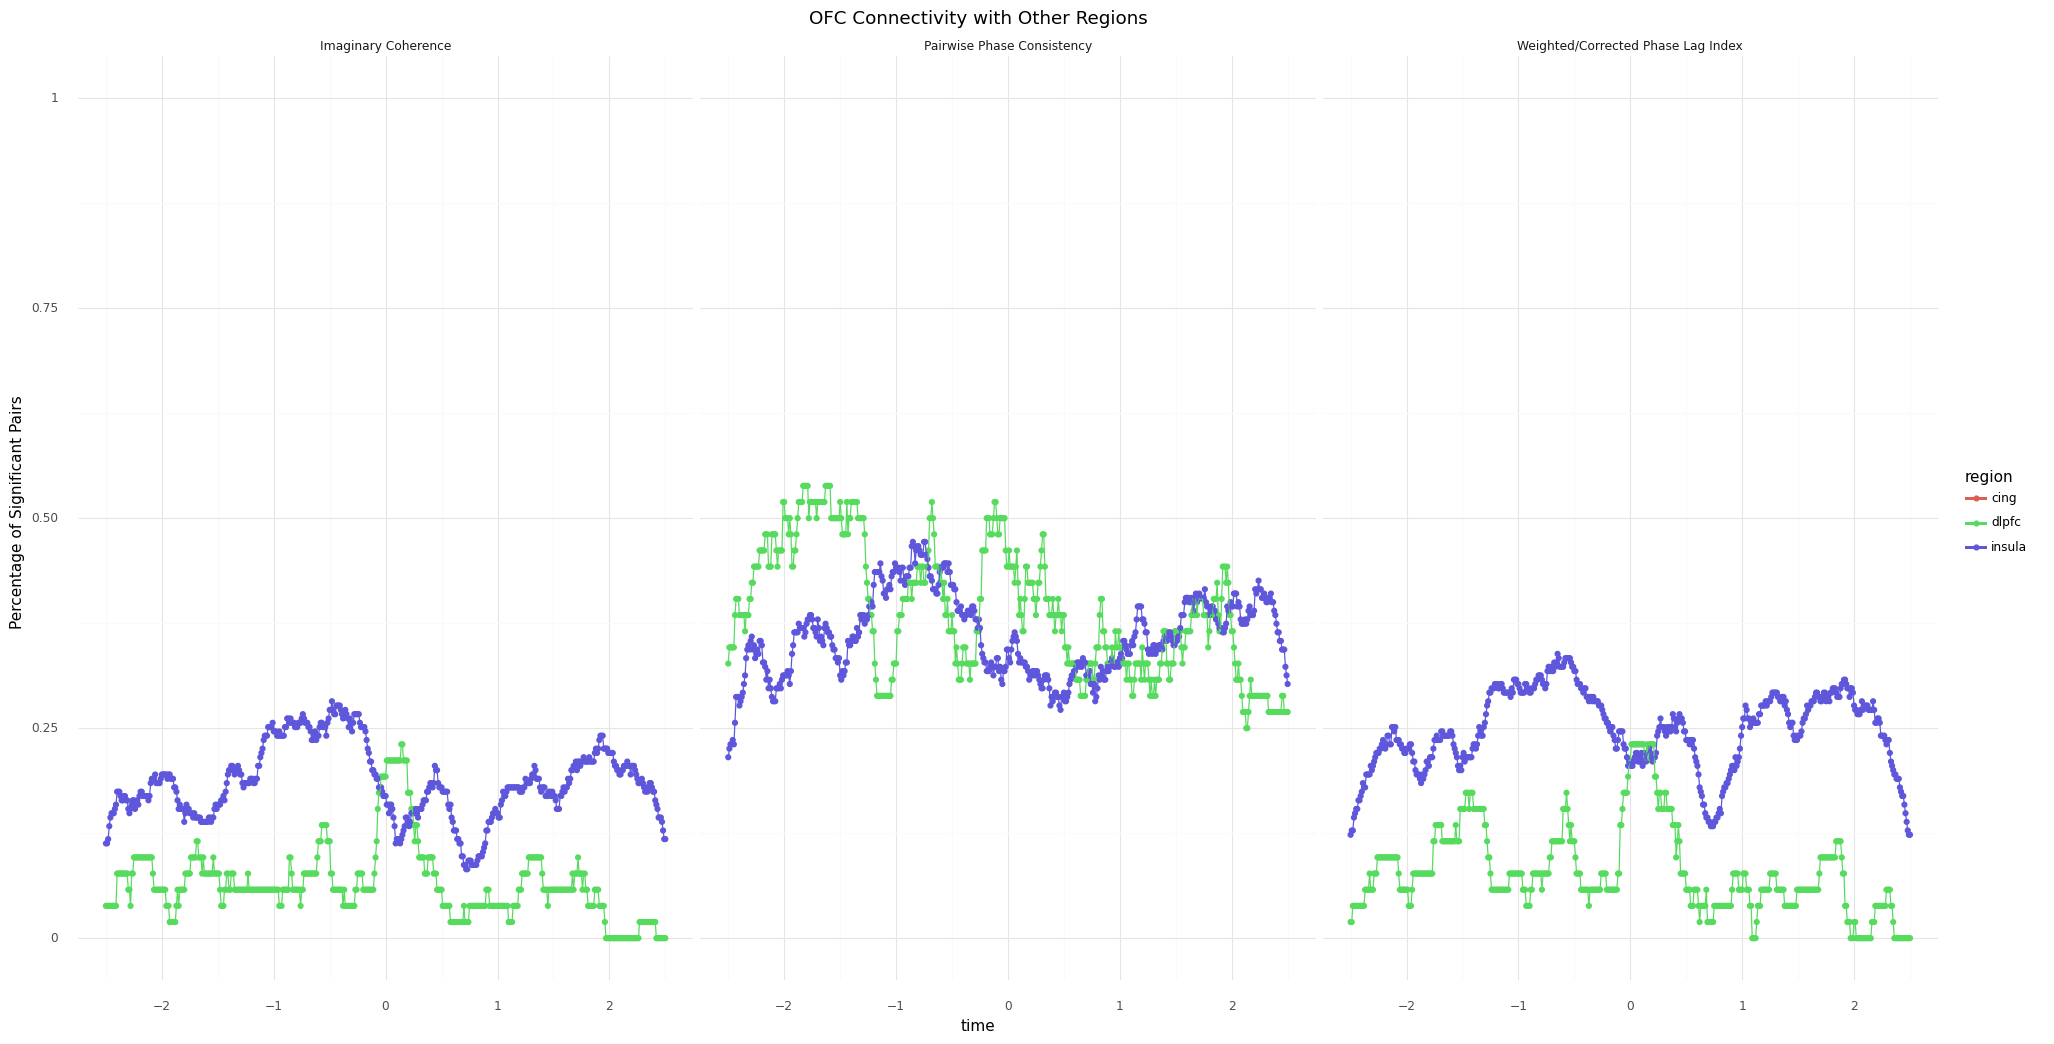

<ggplot: (8734669023013)>

In [24]:
hc_imcoh_pvalues = np.zeros((3, imcoh.shape[1]))
hc_ppc_pvalues = np.zeros((3, imcoh.shape[1]))
hc_pli_pvalues = np.zeros((3, imcoh.shape[1]))

for idx, roi_list in enumerate([cing_list, dlpfc_list, insula_list]):
    first, second = get_indices_of_connectivity_pairs([ofc_list, roi_list], last_away_roi.info['ch_names'])
    pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]


    ### IMCOH ###
    hc_amyg_imcoh_pvals = imcoh_pvalues[pair_indices, :]
    hc_amyg_imcoh_sig = hc_amyg_imcoh_pvals <= 0.05
    hc_amyg_imcoh_counts = np.sum(hc_amyg_imcoh_sig, axis =0)/len(pair_indices)

    ### PPC ###
    hc_amyg_ppc_pvals = ppc_pvalues[pair_indices, :]
    hc_amyg_ppc_sig = hc_amyg_ppc_pvals <= 0.05
    hc_amyg_ppc_counts = np.sum(hc_amyg_ppc_sig, axis =0)/len(pair_indices)

    ### PLI ###
    hc_amyg_pli_pvals = pli_pvalues[pair_indices, :]
    hc_amyg_pli_sig = hc_amyg_pli_pvals <= 0.05
    hc_amyg_pli_counts = np.sum(hc_amyg_pli_sig, axis =0)/len(pair_indices)


    hc_imcoh_pvalues[idx, :] =  hc_amyg_imcoh_counts
    hc_ppc_pvalues[idx, :] = hc_amyg_ppc_counts
    hc_pli_pvalues[idx, :] = hc_amyg_pli_counts


## prep dataframes for plotting ##
# imcoh
hc_imcoh_df = pd.DataFrame(np.transpose(hc_imcoh_pvalues), columns = ['cing', 'dlpfc', 'insula'])
hc_imcoh_df['time'] = last_away_roi.times
hc_imcoh_df = hc_imcoh_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_imcoh_df['metric'] = 'Imaginary Coherence'

# ppc
hc_ppc_df = pd.DataFrame(np.transpose(hc_ppc_pvalues), columns = ['cing', 'dlpfc', 'insula'])
hc_ppc_df['time'] = last_away_roi.times
hc_ppc_df = hc_ppc_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_ppc_df['metric'] = 'Pairwise Phase Consistency'

# pli
hc_pli_df = pd.DataFrame(np.transpose(hc_pli_pvalues), columns = ['cing', 'dlpfc', 'insula'])
hc_pli_df['time'] = last_away_roi.times
hc_pli_df = hc_pli_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_pli_df['metric'] = 'Weighted/Corrected Phase Lag Index'

# combine
hc_df = pd.concat([hc_imcoh_df, hc_ppc_df, hc_pli_df])
hc_df

(ggplot(hc_df, aes(x='time', y='percent_sig', color = 'region')) + 
    geom_point() +
    geom_line() +
    facet_wrap('metric', ncol = 3) +
    theme_minimal() +
    ylim(0, 1) +
    ylab("Percentage of Significant Pairs")+
    ggtitle('OFC Connectivity with Other Regions') +
    theme(figure_size=(24, 12))) 




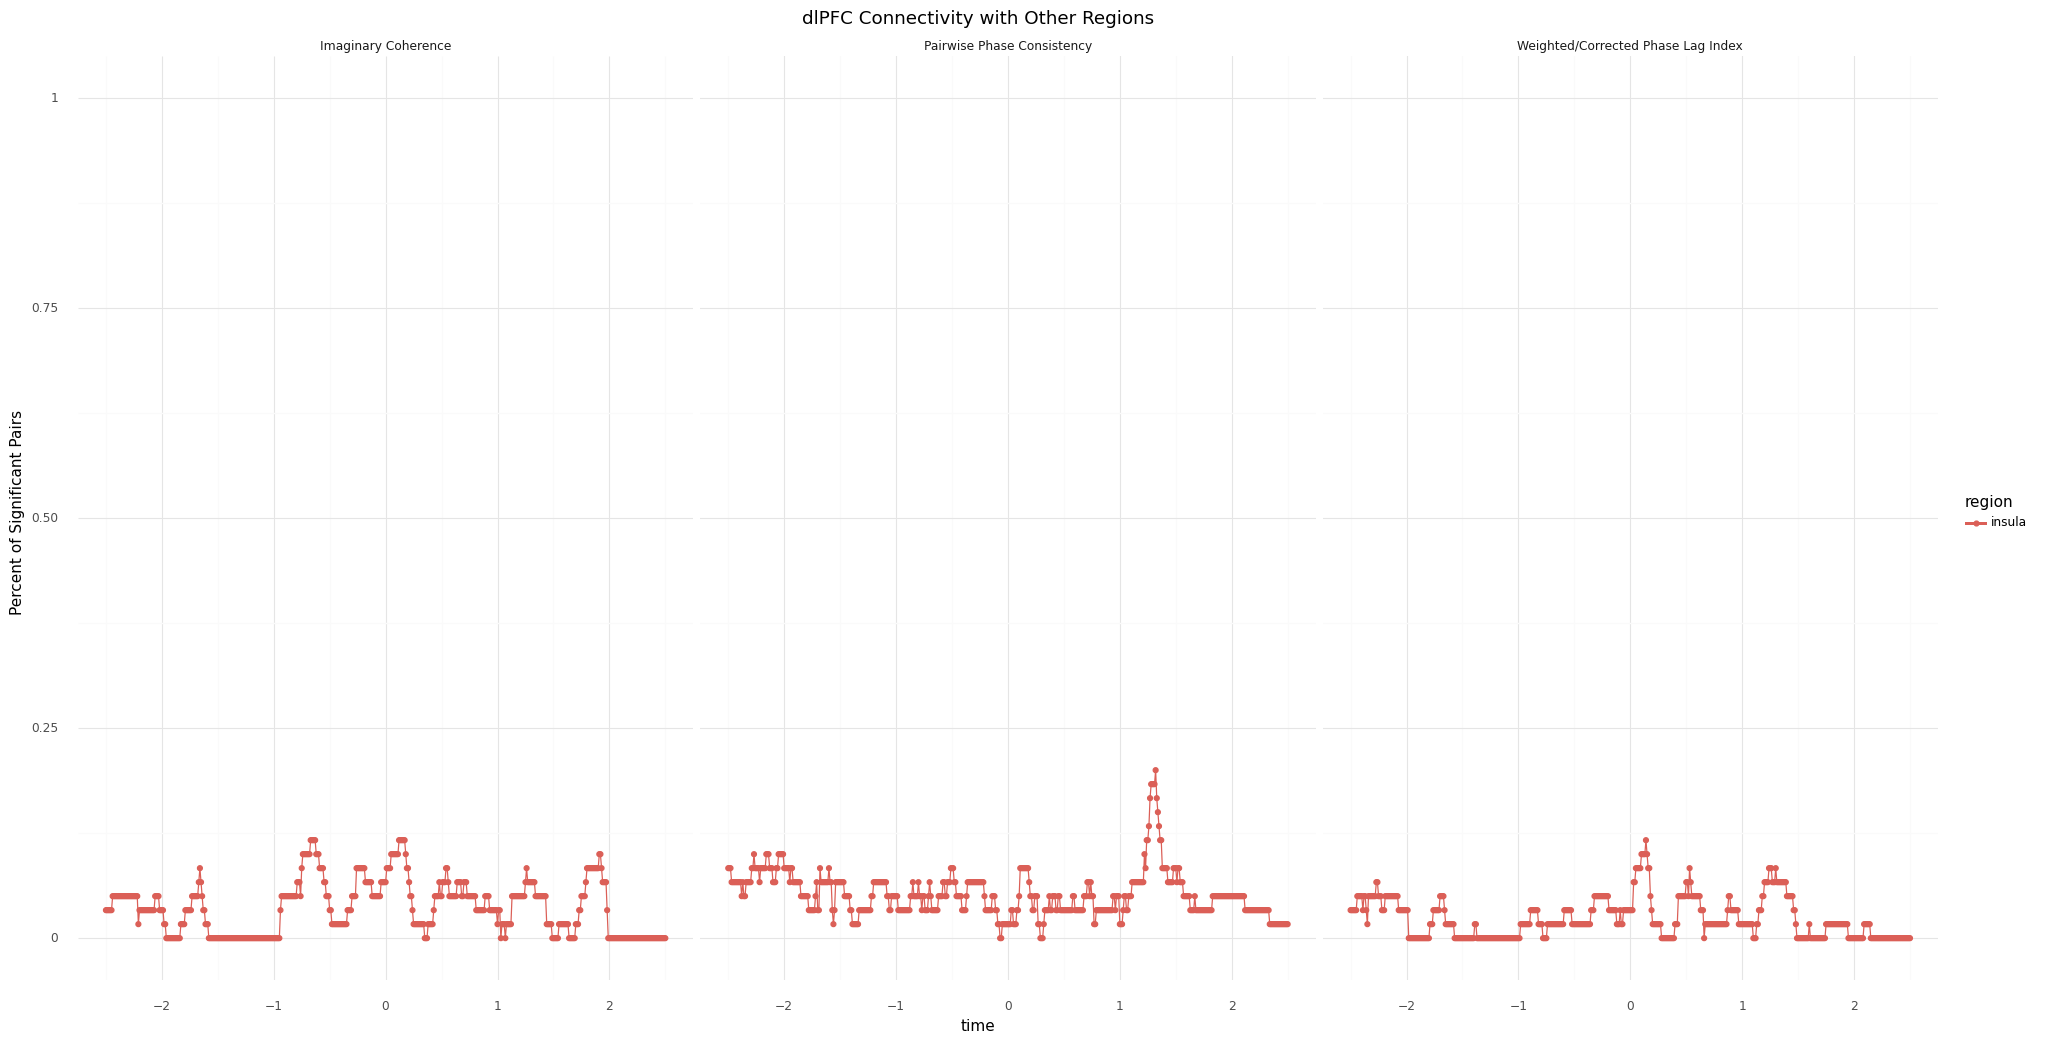

<ggplot: (8734714377418)>

In [26]:
hc_imcoh_pvalues = np.zeros((1, imcoh.shape[1]))
hc_ppc_pvalues = np.zeros((1, imcoh.shape[1]))
hc_pli_pvalues = np.zeros((1, imcoh.shape[1]))

for idx, roi_list in enumerate([insula_list]):
    first, second = get_indices_of_connectivity_pairs([dlpfc_list, roi_list], last_away_roi.info['ch_names'])
    pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]


    ### IMCOH ###
    hc_amyg_imcoh_pvals = imcoh_pvalues[pair_indices, :]
    hc_amyg_imcoh_sig = hc_amyg_imcoh_pvals <= 0.05
    hc_amyg_imcoh_counts = np.sum(hc_amyg_imcoh_sig, axis =0)/len(pair_indices)

    ### PPC ###
    hc_amyg_ppc_pvals = ppc_pvalues[pair_indices, :]
    hc_amyg_ppc_sig = hc_amyg_ppc_pvals <= 0.05
    hc_amyg_ppc_counts = np.sum(hc_amyg_ppc_sig, axis =0)/len(pair_indices)

    ### PLI ###
    hc_amyg_pli_pvals = pli_pvalues[pair_indices, :]
    hc_amyg_pli_sig = hc_amyg_pli_pvals <= 0.05
    hc_amyg_pli_counts = np.sum(hc_amyg_pli_sig, axis =0)/len(pair_indices)


    hc_imcoh_pvalues[idx, :] =  hc_amyg_imcoh_counts
    hc_ppc_pvalues[idx, :] = hc_amyg_ppc_counts
    hc_pli_pvalues[idx, :] = hc_amyg_pli_counts


## prep dataframes for plotting ##
# imcoh
hc_imcoh_df = pd.DataFrame(np.transpose(hc_imcoh_pvalues), columns = ['insula'])
hc_imcoh_df['time'] = last_away_roi.times
hc_imcoh_df = hc_imcoh_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_imcoh_df['metric'] = 'Imaginary Coherence'

# ppc
hc_ppc_df = pd.DataFrame(np.transpose(hc_ppc_pvalues), columns = ['insula'])
hc_ppc_df['time'] = last_away_roi.times
hc_ppc_df = hc_ppc_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_ppc_df['metric'] = 'Pairwise Phase Consistency'

# pli
hc_pli_df = pd.DataFrame(np.transpose(hc_pli_pvalues), columns = ['insula'])
hc_pli_df['time'] = last_away_roi.times
hc_pli_df = hc_pli_df.melt(id_vars = 'time', var_name='region', value_name='percent_sig')
hc_pli_df['metric'] = 'Weighted/Corrected Phase Lag Index'

# combine
hc_df = pd.concat([hc_imcoh_df, hc_ppc_df, hc_pli_df])
hc_df

(ggplot(hc_df, aes(x='time', y='percent_sig', color = 'region')) + 
    geom_point() +
    geom_line() +
    facet_wrap('metric', ncol = 3) +
    theme_minimal() +
    ylim(0, 1) +
    ylab("Percent of Significant Pairs")+
    ggtitle('dlPFC Connectivity with Other Regions') +
    theme(figure_size=(24, 12))) 




### Individual Electrode Plots

In [ ]:
first, second = get_indices_of_connectivity_pairs([hc_list, amyg_list], last_away_roi.info['ch_names'])
pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]

for pair in pair_indices[0:10]:

    greater_than_null = pli[pair, :] >= pli_permutations[pair, :, 0:500] 
    percent_greater_than_null = np.sum(greater_than_null, axis = 0)/1000

    imcoh_sig = (percent_greater_than_null >= .95) 
    imcoh_sig_plot = np.where(imcoh_sig, 0.2, np.nan)

    plt.figure(figsize=(20, 12))
    plt.plot(last_away_roi.times[0:500], pli[pair, :])
    plt.plot(last_away_roi.times[0:500], imcoh_sig_plot, color = 'black')

    for perm in range(0, 1000):
        plt.plot(last_away_roi.times[0:500], pli_permutations[pair, perm, 0:500], color = 'lightgrey', alpha = 0.1)

    plt.title(f'PLI {pairs_tested[pair]}')

    plt.show()

In [ ]:
first, second = get_indices_of_connectivity_pairs([hc_list, amyg_list], last_away_roi.info['ch_names'])
pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]

for pair in pair_indices[0:10]:

    imcoh_sig = (imcoh_pvalues[pair, :] < .05) 
    imcoh_sig_plot = np.where(imcoh_sig, 0.2, np.nan)

    plt.figure(figsize=(20, 12))
    plt.plot(last_away_roi.times[0:500], imcoh[pair, :])
    plt.plot(last_away_roi.times[0:500], imcoh_sig_plot, color = 'black')

    for perm in range(0, 1000):
        plt.plot(last_away_roi.times[0:500], imcoh_permutations[pair, perm, 0:500], color = 'lightgrey', alpha = 0.1)

    plt.title(f'IMCOH {pairs_tested[pair]}')

    plt.show()

In [ ]:
first, second = get_indices_of_connectivity_pairs([hc_list, amyg_list], last_away_roi.info['ch_names'])
pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]

for pair in pair_indices[0:10]:

    imcoh_sig = (ppc_pvalues[pair, :] < .05) 
    imcoh_sig_plot = np.where(imcoh_sig, 0.075, np.nan)

    plt.figure(figsize=(20, 12))
    plt.plot(last_away_roi.times[0:500], ppc[pair, :])
    plt.plot(last_away_roi.times[0:500], imcoh_sig_plot, color = 'black')

    for perm in range(0, 1000):
        plt.plot(last_away_roi.times[0:500], ppc_permutations[pair, perm, 0:500], color = 'lightgrey', alpha = 0.1)

    plt.title(f'PPC {pairs_tested[pair]}')

    plt.show()

## HC ~ Insula

In [ ]:
first, second = get_indices_of_connectivity_pairs([hc_list, insula_list], last_away_roi.info['ch_names'])
pair_indices = [idx for idx, pair in enumerate(zip(first_pair_indices, second_pair_indices)) if pair in zip(first, second)]

# for pair in pair_indices:

upper_percentiles = np.percentile(imcoh_permutations[pair, :, 0:500], 95, axis=0)
lower_percentiles = np.percentile(imcoh_permutations[pair, :, 0:500], 5, axis=0)
imcoh_sig = (imcoh[pair, :] >= upper_percentiles) | (imcoh[pair, :] <= lower_percentiles)
imcoh_sig_plot = np.where(imcoh_sig, 0.2, np.nan)

plt.figure(figsize=(20, 12))
plt.plot(last_away_roi.times[0:500], imcoh[pair, :], color = '#f15bb5')
plt.plot(last_away_roi.times[0:500], imcoh_sig_plot, color = 'black')

for perm in range(0, 1000):
    plt.plot(last_away_roi.times[0:500], imcoh_permutations[pair, perm, 0:500], color = 'lightgrey', alpha = 0.1)

plt.title(f'IMCOH {pairs_tested[pair]}')

plt.show()